<a href="https://colab.research.google.com/github/NeoNeuron/CCN2021_TUT/blob/main/RNN.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

---

# Recurrent Neural Network: settings and dynamics

**Content Creator:** Yuxiu Shao

The general RNN dynamics are given by

$$\frac{d x_{i}(t)}{d t}=-x_{i}(t)+\sum_{j=1}^{N} J_{i j} \phi(x_{j}(t))+h_{i}(t).$$

Variable $x_i$ represents the input current entering neuron $i$, while $\phi(x_i)$ represents the output firing rate. $J_{ij}$ is a $N\times N$ matrix representing recurrent connectivity, and $h_i$ is the external input received by neuron $i$.


![RNN](https://www.researchgate.net/publication/296477115/figure/fig11/AS:342923364323334@1458770709221/Recurrent-neural-network-RNN-A-trained-RNN-of-excitatory-and-inhibitory-rate-units.png)


In this tutorial, like in the first part of the lecture, we generate the recurrent connectivity at random from a Gaussian distribution: we set 
$$J_{ij}\sim \mathcal{N}\left(0, \frac{g^2}{N}\right).$$

In this tutorial, we assume the system is autonomous that neurons receive no input: $h_{i}(t)=0$.

How can we study the dynamics that emerge from this set of equations, where the activity of each neuron input current variable $x_i(t)$ is strongly dependent on the behavior of many other variables?
We follow the approach used in **Dynamical Systems Theory** and start our analysis by looking for special activity states, i.e. **fixed points**, that we indicate by $\mathbf{x}^* = [x^*_1, \dots, x^*_N]^T$ (written as a column vector). At the fixed points, current variables are stationary (i.e. they do not vary over time). Fixed point states thus obey:
$$\frac{d x_{i}}{d t}\biggr\rvert_{x_i=x_i^*}=0 \implies x_i^* = \sum_{j=1}^{N} J_{i j} \phi(x_{j}^*).$$

In [1]:
# @title Excecute cell to initialize
# @markdown Import Numpy, Matplotlib, etc.
# @markdown Setup plot configurations
import matplotlib.pyplot as plt
import numpy as np
fig_width = 4.2 # width in inches
fig_height = 3.  # height in inches
fig_dpi = 150
fig_size =  [fig_width,fig_height]
plt.rcParams['figure.figsize'] = fig_size
plt.rcParams['figure.dpi'] = fig_dpi
plt.rcParams['figure.autolayout'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['text.usetex']=True

## Linear RNN

We first consider a linear RNN: we take
$$\phi(x)=x,$$
and write down the fixed point equation in this case. This equation admits a very simple fixed point $\mathbf{x}^*$. 
- Can you guess what this fixed point is?
- Do you think that this fixed point is the only one admitted by the dynamics?

### Investigate the distribution of **eigenvalues**

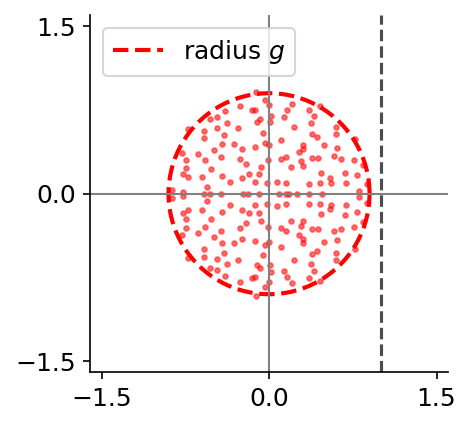

In [2]:
# Generate network parameters
# ---------------------------

N = 200              # Network size
g = 0.9              # Connectivity strength

# recurrent connectivity
np.random.seed(0)
J = g/np.sqrt(N) * np.random.normal(0, 1., (N,N))

# calculate the eigenvalues and eigenvectors
eigvJ,eigrvecJ=np.linalg.eig(J)

# Plot eigenspectrum of J
fig, ax0 = plt.subplots(1,1)

# phase transition
line = ax0.axvline(1, ls='--', color = '0.3')
# Plot eigenspectrum of J
plt.scatter(np.real(eigvJ),np.imag(eigvJ),s=5,c='red',alpha=0.5)

# axes settings
xticks = np.linspace(-1.5,1.5,3)
xlims  = [-1.6,1.6]
yticks = np.linspace(-1.5,1.5,3)
ylims  = [-1.6,1.6]
theta  = np.linspace(0, 2 * np.pi, 200)

# radius
xr = g*np.cos(theta)
yr = g*np.sin(theta)
ax0.plot(xr, yr, color="red", linewidth=2.,linestyle='--',label=r'radius $g$')
ax0.axvline(c='grey', lw=1)
ax0.axhline(c='grey', lw=1)
ax0.set_xlim(xlims)
ax0.set_ylim(ylims)
ax0.set_xticks(xticks)
ax0.set_yticks(yticks)
ax0.set_aspect('equal')
ax0.legend()
plt.show()


## Nonlinear RNN 

Now we introduce nonlinear $\phi(x)$, and try to solve it numerically.


In [3]:
# >>>>>>>>>>>>>>>>>>>> trying dynamics
from scipy.optimize import fsolve,leastsq,minimize
import scipy.integrate
from functools import partial
# define Ordinary Differential Equation
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    # x = np.reshape(x,(-1,1))
    dxdt =-x+J@(1+np.tanh(x))/2.0 #x#np.tanh(x)#0.5*(1+np.tanh(x))#
    return np.squeeze(dxdt)
def idesimulation(t,xinit,Jpt,I):
    # use partial to freeze parameter for J and I.
    return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)


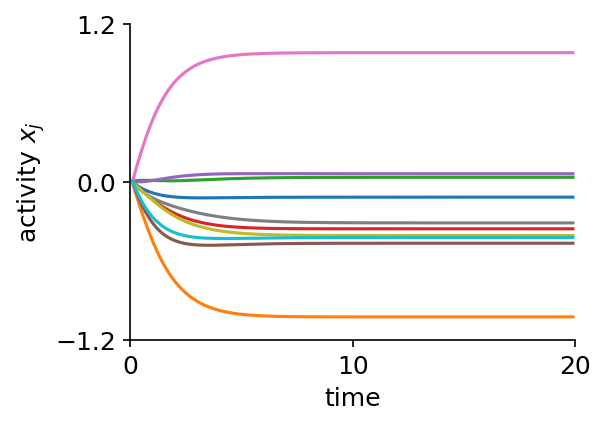

In [4]:
# simulating parameters
dt,ft = 0.1,20
tt = np.arange(dt,ft,dt)
# guessing initial FP
np.random.seed(0)
xinit = -0.01*np.random.randn(N)
dynactivity = idesimulation(tt,xinit,J,0)

# plot dynamic activity 
fg = plt.figure()
ax0 = plt.axes(frameon=True)
# random sampling neurons
np.random.seed(0)
idxsample = np.random.choice(N,10, replace=False)
for _,idx in enumerate(idxsample):
    plt.plot(tt, dynactivity[:,idx])

plt.xlabel('time')
plt.ylabel(r'activity $x_j$')
plt.xlim(0, ft)
plt.ylim(-1, 1.)
plt.xticks([0, ft//2, ft])
plt.yticks([-1.2, 0, 1.2])
plt.show()


### **Bonus** 

We have learnt from the previous point that approximately when $g>1$, activity diverges away from the zero fixed point.

We consider here a different issue.
In the RNN we just examined, we assumed two cases $\phi(x)=x$ and $\phi(x)=\tanh(x)$. Therefore we were able to easily guess the value of the fixed point that is admitted by the dynamics, and evaluate activity evolution around it. In RNNs characterized by a more general activation function, guessing the fixed points can be hard, because easy guesses do not work. For example, we will use an activation function that generates only positive firing rates:
$$\phi(x)=\frac{1}{2}\left(\tanh(x)+1\right).$$
 A way of doing this is to use numerics to solve the fixed point equations. 
Choose a solver in your favourite programming language, and solve the fixed point equations numerically. Use $N=50$, $g=0.8$. 

*Hint: in Python, you can use the function root from the scipy.optimize package*.

What is the value of the fixed point? Is the current variable $x_i^*$ for every neuron the same as in the simple fixed point? Print the histogram of entries $x_i^*$; then go back to $\phi(x)=\tanh(x)$, and plot the histogram!

(array([ 6., 16., 26., 38., 39., 27., 25., 12.,  7.,  4.]),
 array([-1.15165032, -0.90028989, -0.64892946, -0.39756903, -0.1462086 ,
         0.10515183,  0.35651226,  0.60787268,  0.85923311,  1.11059354,
         1.36195397]),
 <a list of 10 Patch objects>)

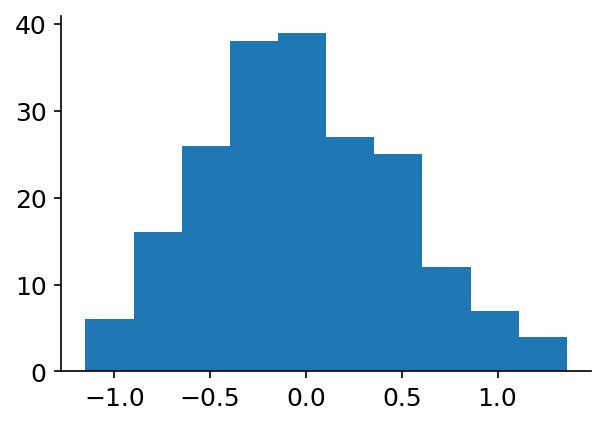

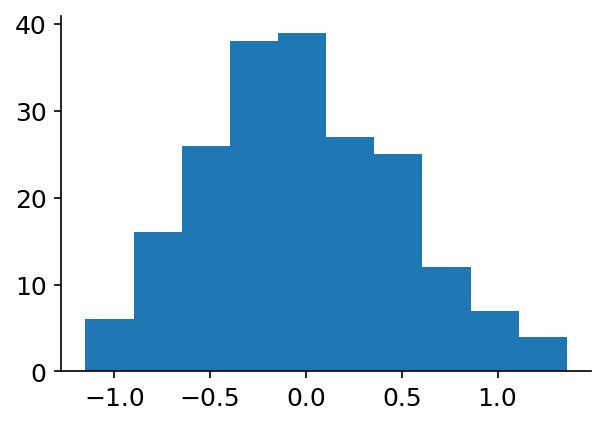

In [5]:
# simulating parameters
dt,ft = 0.1,20
tt = np.arange(dt,ft,dt)
# guessing initial FP
xinit = -0.01*np.random.randn(N)
dynactivity = idesimulation(tt,xinit,J,0)

# plot histogram of dynamic activity (stable activity)
fg = plt.figure()
plt.hist(dynactivity[-1,:],bins=10)


# solve the nonlinear equation
def solveFP(x,J):
  return J@(np.tanh(x)+1)/2.0-x # J@np.tanh(x)-x #
root = fsolve(solveFP, xinit,J)



# Plot the histogram
fg = plt.figure()
plt.hist(root,bins=10)

## RNN with different drives

**Now** we try to build and simulate a RNN which also receives a periodic input of frequency $\omega$
$$ h_i = I \cos(\omega t + \theta_i) $$
where phases $\theta_i$ are distributed uniformely across neurons. To begin with, the value of $I$ is set to zero. 

The code still uses Euler's method to simulate the RNN activity by integrating numerically both the recurrent input and the feedforward input. Dynamics is simulated between $0$ and final $T=100$ with discretized time step $\Delta t = 0.01$, and then use:
$$x_{i,t+1} = x_{i,t} + \Delta t \frac{d x_{i,t}}{d t} = 
(1 - \Delta t )x_{i,t} + \Delta t \left[ \sum_{j=1}^{N} J_{i j} \phi\left(x_{j,t}\right)+h_{i,t} \right].$$

In [6]:
# Generate network

N = 500      # Network size
g = 1.8      # Connectivity strength
I = 0.1      # Input strength
omega = 2.5  # Input frequency

# Connectivity

J = g/np.sqrt(N) * np.random.normal(0, 1., (N,N))
eig = np.linalg.eigvals(J)

# Input phases

theta = 2. * np.pi * np.random.uniform(0, 1., N)

# Simulate activity 

# Function simulating one time step

# def sim_step (x_step, t_step):
#   x_step = (1.0-dt) * x_step + dt * np.dot(J, np.tanh(x_step)) + dt * I * np.cos(omega*t_step + theta)
#   return x_step

# Parameters
T = 1000                      			# Total time
dt = 0.01                       	 	# Time step
t_step = np.linspace(0, T, int(T/dt))	# Time array

# Activity vector (time x neurons), initialize with normal distribution

x_init = np.random.normal(0, 1., N)

from scipy.integrate import solve_ivp
FODE = lambda t, s: -s +J@np.tanh(s)+ I*np.cos(omega*t +theta)

t_eval = np.arange(0, T, 0.1)
sol = solve_ivp(FODE, [0, T], x_init, t_eval=t_eval)


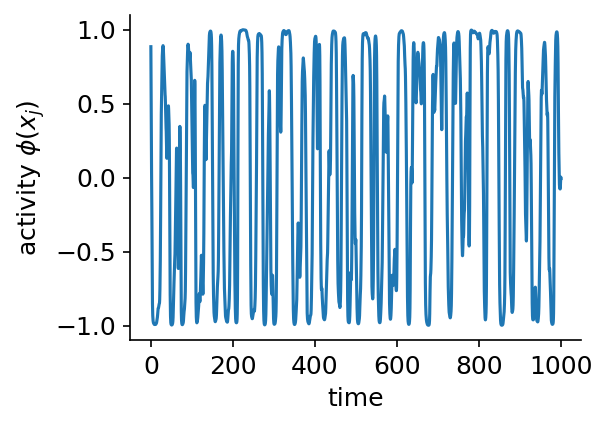

In [7]:
# phi(x) Activity
neuronactivity = np.tanh(sol.y)
fg = plt.figure()
plt.plot(t_eval, neuronactivity.T[:,130])

plt.xlabel('time')
plt.ylabel(r'activity $\phi(x_j)$')
plt.show()